In [69]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# for lasso and ridge
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# for XGBoost
import xgboost

# suppress warnings which are so irritating
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [46]:
file = pd.read_csv("train_data.csv")
# file = file.sample(5000) # for building model purpose, disable when produce

In [47]:
'''
work on the start timestamp, create the following features
    - which hour the journey starts
    - which day of week the journey starts
    - which day the journey starts
    - which month the journey starts
    - which year the journey starts
    
'''
def TimestampOps(df):
    # convert TIMESTAMP from Series to Datetime object
    df['TIMESTAMP'] = pd.to_datetime(df.TIMESTAMP, format="%Y-%m-%d %H:%M:%S")
    df["START_YEAR"] = df['TIMESTAMP'].dt.year
    df["START_MONTH"] = df['TIMESTAMP'].dt.month
    df["START_DAY"] = df['TIMESTAMP'].dt.day
    df["START_DOW"] = df['TIMESTAMP'].dt.weekday() # Monday is 0, Sunday is 6
    df["START_HOUR"] = df['TIMESTAMP'].dt.hour


In [48]:
'''
work on X_START, Y_START, Y_START, Y_END
    - group the start and end location into 4 different districts: SW, SE, NW and NE
    - find direct euclidean distance 
    - binary that tells whether the start and end are in the same district
'''

def find_district(x, y, mid_X, mid_Y):
    if x < mid_X and y < mid_Y:
        return "SW"
    elif x < mid_X and y > mid_Y:
        return "NW"
    elif x > mid_X and y < mid_Y:
        return "SE"
    else:
        return "NE"
    
def direct_length(x1, x2, y1, y2):
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

def StartEndOps(df):
    # examine X and Y ranges
    min_X = min(df["X_START"].min(), df['X_END'].min())
    min_Y = min(df["Y_START"].min(), df['Y_END'].min())
    max_X = max(df["X_START"].max(), df['X_END'].max())
    max_Y = max(df["Y_START"].max(), df['Y_END'].max())

    # create the district by spliting from the mid
    mid_X = (max_X + min_X)/2
    mid_Y = (max_Y + min_Y)/2

    df["START_DISTRICT"] = df.apply(lambda row: find_district(row['X_START'], row['Y_START'], mid_X, mid_Y), axis=1)
    df["END_DISTRICT"] = df.apply(lambda row: find_district(row['X_END'], row['Y_END'], mid_X, mid_Y), axis=1)
    df["DIRECT_LENGTH"] = df.apply(lambda row: direct_length(row["X_START"], row['X_END'], row["Y_START"], row['Y_END']), axis=1)
    df["SAME_DISTRICT"] = np.where(df["START_DISTRICT"] == df["END_DISTRICT"], 1, 0)


In [49]:
def CleanupOps(df):
    # log transformation of the numeric columns
    df["DURATION"] = np.log(df["DURATION"])
    df["TRAJ_LENGTH"] = np.log(df["TRAJ_LENGTH"])
    df["DIRECT_LENGTH"] = np.log(df["DIRECT_LENGTH"])
    
    # remove unneeded columns
    df.drop(["TIMESTAMP", "X_START", "Y_START", "X_END", "Y_END", "ID", "X_TRAJECTORY", "Y_TRAJECTORY"], axis=1, inplace=True)
    
    # clear up data type
    for i in ["TAXI_ID", "START_YEAR", "START_MONTH", "START_DAY", "START_DOW", "START_HOUR", "START_DISTRICT", "END_DISTRICT",
             "SAME_DISTRICT"]:
        df[i] = df[i].astype(np.object)

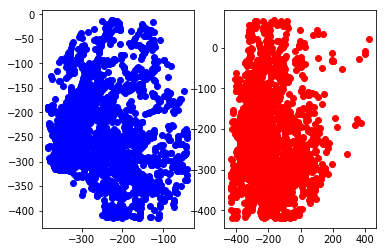

In [50]:
fig, axs = plt.subplots(1,2)
samples = file.sample(5000)
# Plot start point of the journey
axs[0].plot(samples["X_START"], samples["Y_START"], 'bo')
# Plot end point of the journey
axs[1].plot(samples["X_END"], samples["Y_END"], 'ro')

In [53]:
# preprocessing
TimestampOps(file)
StartEndOps(file)
CleanupOps(file)

# create one-hot encoding for all the categorical values
file = pd.get_dummies(file)

file.head()

DURATION  TRAJ_LENGTH  DIRECT_LENGTH  TAXI_ID_1  TAXI_ID_2  TAXI_ID_3  \
0  5.407172     6.084499       5.788053          0          0          0   
1  5.883322     5.560682       5.436394          0          0          0   
2  5.087596     4.905275       3.861560          0          0          0   
3  4.820282     4.248495       3.954194          0          0          0   
4  5.389072     4.762174       4.428615          0          0          0   

   TAXI_ID_4  TAXI_ID_5  TAXI_ID_6  TAXI_ID_7       ...         START_HOUR_22  \
0          0          0          0          0       ...                     0   
1          0          0          0          0       ...                     0   
2          0          0          0          0       ...                     0   
3          0          0          0          0       ...                     0   
4          0          0          0          0       ...                     0   

   START_HOUR_23  START_DISTRICT_NW  START_DISTRICT_SW  END_DISTRICT_NE  \
0              0                  0                  1                0   
1              0                  1                  0                0   
2              0                  0                  1                0   
3              0                  0                  1                0   
4              0                  0                  1                0   

   END_DISTRICT_NW  END_DISTRICT_SE  END_DISTRICT_SW  SAME_DISTRICT_0  \
0                1                0                0                1   
1                0                0                1                1   
2                0                0                1                0   
3                0                0                1                0   
4                0                0                1                0   

   SAME_DISTRICT_1  
0                0  
1                0  
2                1  
3                1  
4                1  

[5 rows x 887 columns]

In [57]:
# read test data and preprocess
test = pd.read_csv('test.csv')
TimestampOps(test)
StartEndOps(test)

In [58]:
# log transformation of the numeric columns
test["DIRECT_LENGTH"] = np.log(test["DIRECT_LENGTH"])

# remove unneeded columns
test.drop(["TIMESTAMP", "X_START", "Y_START", "X_END", "Y_END"], axis=1, inplace=True)

# clear up data type
for i in ["TAXI_ID", "START_YEAR", "START_MONTH", "START_DAY", "START_DOW", "START_HOUR", "START_DISTRICT", "END_DISTRICT",
         "SAME_DISTRICT"]:
    test[i] = test[i].astype(np.object)
test = pd.get_dummies(test)

test.head()

ID  DIRECT_LENGTH  TAXI_ID_1  TAXI_ID_2  TAXI_ID_3  TAXI_ID_4  \
0  465173       4.180153          0          0          0          0   
1  465174       4.152618          0          0          0          0   
2  465175       4.807636          0          0          0          0   
3  465176       5.877771          0          0          0          0   
4  465177       4.670333          0          0          0          0   

   TAXI_ID_5  TAXI_ID_6  TAXI_ID_7  TAXI_ID_8       ...         START_HOUR_22  \
0          0          0          0          0       ...                     0   
1          0          0          0          0       ...                     0   
2          0          0          0          0       ...                     0   
3          0          0          0          0       ...                     0   
4          0          0          0          0       ...                     0   

   START_HOUR_23  START_DISTRICT_NW  START_DISTRICT_SW  END_DISTRICT_NE  \
0              0                  1                  0                0   
1              0                  1                  0                0   
2              0                  0                  1                0   
3              0                  1                  0                0   
4              0                  0                  1                0   

   END_DISTRICT_NW  END_DISTRICT_SE  END_DISTRICT_SW  SAME_DISTRICT_0  \
0                1                0                0                0   
1                0                0                1                1   
2                0                0                1                0   
3                0                0                1                1   
4                0                0                1                0   

   SAME_DISTRICT_1  
0                1  
1                0  
2                1  
3                0  
4                1  

[5 rows x 886 columns]

In [59]:
# save processed train and test into csv files.
file.to_csv("proc_train.csv")
test.to_csv("proc_test.csv")

In [ ]:
# lasso regression with 10 fold validation
dur_lasso = linear_model.LassoCV(cv = 10)
# traj_lasso = linear_model.Lasso()

train_X = file.drop(["DURATION", "TRAJ_LENGTH"], axis=1)

# lasso_dur_pipe = make_pipeline(dur_lasso)
# %time cross_val_score(lasso_dur_pipe, train_X, file['DURATION'], cv=10, scoring='neg_mean_squared_error').mean()

%time dur_lasso.fit(train_X, file['DURATION'])
# %time traj_lasso.fit(train_X, file['TRAJ_LENGTH'])


In [81]:
# lasso initial prediction 
# %time dur_lasso_pred = dur_lasso.predict(test.drop(["ID"], axis=1))
# %time traj_lasso_pred = traj_lasso.predict(test.drop(["ID"], axis=1))

CPU times: user 3.02 s, sys: 3.97 s, total: 6.99 s
Wall time: 9.79 s
CPU times: user 2.61 s, sys: 1.98 s, total: 4.58 s
Wall time: 5.36 s


In [79]:
# dur_lasso_pred = np.exp(dur_lasso_pred)


array([ 5.32217114,  5.32217114,  5.32217114, ...,  5.32217114,
        5.32217114,  5.32217114])

In [ ]:
# xgboost regressor for both duration and trajection length. This also takes forever, DEPRECIATE
dur_xgb = xgboost.XGBRegressor(n_estimators=500, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=0.7, max_depth=7, silent = False)

tra_xgb = xgboost.XGBRegressor(n_estimators=500, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=0.7, max_depth=7, silent = False)

train_X = file.drop(["DURATION", "TRAJ_LENGTH"], axis=1)

%time dur_xgb.fit(train_X, file["DURATION"])
# %time tra_xgb.fit(train_X, file["TRAJ_LENGTH"])

In [54]:
# test on lasso regression with 10-folds cross validation and grid search, this takes forever, DEPRECIATED
dur_lasso = linear_model.Lasso()
traj_lasso = linear_model.Lasso()

param_grid = {
    "lasso__alpha" : [-1, 1, 0.5, -0.5, 2, -2]
}

train_X = file.drop(["DURATION", "TRAJ_LENGTH"], axis=1)

# lasso prediction score for duration
dur_pipe = make_pipeline(dur_lasso)
dur_grid = GridSearchCV(dur_pipe, param_grid, cv=10, scoring='neg_mean_squared_error')
%time dur_grid.fit(train_X, file["DURATION"])

print(dur_grid.best_score_)
print(dur_grid.best_params_)

# lasso prediction score for trajection length
traj_pipe = make_pipeline(traj_lasso)
traj_grid = GridSearchCV(traj_pipe, param_grid, cv=10, scoring='neg_mean_squared_error')
%time traj_grid.fit(train_X, file["TRAJ_LENGTH"])

print(traj_grid.best_score_)
print(traj_grid.best_params_)

traj_pred_lasso = traj_grid.predict(test)
# dur_pred_lasso = traj_grid.predict()
# pd.DataFrame({'ID':test.ID, 'PRICE':new_pred_class_rand}).set_index('ID').to_csv('test_results.csv')